# Emoji Model

In [1]:
!pip install keras
!pip install sklearn
!pip install nltk
!pip install transformers

import matplotlib.pyplot as mpl
import pandas as pd
import numpy as np
import seaborn
from pathlib import Path
from urllib.request import urlopen
import numpy as np
import tensorflow as tf
from urllib.request import urlopen
import nltk
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import metrics
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize, pos_tag_sents
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from keras.preprocessing.sequence import pad_sequences
from nltk.util import pad_sequence
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.pipeline import Pipeline
from keras.preprocessing.text import Tokenizer

In [2]:
def importEmojiDatasets(dataset_name):
    # Download a given dataset from GitHub CDN
    # Data cast to global values

    baseUrl = "https://raw.githubusercontent.com/GDarkens/CE888/main/Assignments/Assignment1/tweeteval/datasets/"

    MAPPING_URL = baseUrl + dataset_name + "/" + "mapping.txt"
    global mapping
    mapping = urlopen(MAPPING_URL).read().decode('utf-8').split("\n")

    TEST_LABELS_URL = baseUrl + dataset_name + "/" + "test_labels.txt"
    global test_labels
    test_labels = urlopen(
        TEST_LABELS_URL).read().decode('utf-8').split("\n")

    TEST_TEXT_URL = baseUrl + dataset_name + "/" + "test_text.txt"
    global test_text
    test_text = urlopen(
        TEST_TEXT_URL).read().decode('utf-8').split("\n")

    TRAIN_LABELS_URL = baseUrl + dataset_name + "/" + "train_labels.txt"
    global train_labels
    train_labels = urlopen(
        TRAIN_LABELS_URL).read().decode('utf-8').split("\n")

    TRAIN_TEXT_URL = baseUrl + dataset_name + "/" + "train_text.txt"
    global train_text
    train_text = urlopen(
        TRAIN_TEXT_URL).read().decode('utf-8').split("\n")

    VAL_LABELS_URL = baseUrl + dataset_name + "/" + "val_labels.txt"
    global val_labels
    val_labels = urlopen(
        VAL_LABELS_URL).read().decode('utf-8').split("\n")

    VAL_TEXT_URL = baseUrl + dataset_name + "/" + "val_text.txt"
    global val_text
    val_text = urlopen(
        VAL_TEXT_URL).read().decode('utf-8').split("\n")

In [3]:
def dataFramer(tweetVar, labelVar):
    #Suitably frames tweets, pairing them with their given label
    tweet_array = []
    label_array = []
    for i in range(len(tweetVar)):
        tweet_array.append({"tweet": tweetVar[i], "label": labelVar[i]})
        label_array.append(i)
    dataframe = pd.DataFrame(tweet_array, index=label_array)
    dataframe = dataframe[:-1]  # Drop last row, as is a blank
    return dataframe

In [4]:
importEmojiDatasets("emoji")  # emoji  / hate /  sentiment

trainingTweets = dataFramer(train_text, train_labels)
testingTweets = dataFramer(test_text, test_labels)
valTweets = dataFramer(val_text, val_labels)

## Text Pre-processing

In [5]:
def fullyProcess(tweetFrame):
    # conda activate myenv
    tweetFrame['processed_tweet'] = tweetFrame['tweet'].str.lower()
    tweetFrame['processed_tweet'] = handleRemover(tweetFrame)
    tweetFrame['processed_tweet'] = punctuationRemover(tweetFrame)
    tweetFrame['processed_tweet'] = stopwordRemoval(tweetFrame)
    tweetFrame['processed_tweet'] = stemmer(tweetFrame)
    tweetFrame['processed_tweet'] = tweetFrame['processed_tweet'].str.strip()
    #tweetFrame['processed_tweet'] = tokenizeSequencePadder((tweetFrame))
    
    #tweetFrame['length'] = tweetFrame['processed_tweet'].apply(lambda x: len(x))
    #tweetFrame['words'] = tweetFrame['processed_tweet'].apply(lambda x: len(x.split()))
    return tweetFrame


def stopwordRemoval(tweetFrame):
    en_Stopwords = stopwords.words("english")
    result = tweetFrame['processed_tweet'].apply(lambda x: ' '.join(
        [item for item in x.split() if item not in en_Stopwords]))
    return result


puncTokenizer = RegexpTokenizer(r'\w+')
def punctuationRemover(tweetFrame):
    result = tweetFrame['processed_tweet'].str.replace(r'[^\w\s]+', '')
    return result


def tokenizeSequencePadder(tweetFrame):
    nltkTokenizer = Tokenizer(num_words = 15000)
    nltkTokenizer.fit_on_texts(tweetFrame['processed_tweet'])
    
    tokenizedFrame = nltkTokenizer.texts_to_sequences(tweetFrame['processed_tweet'])
    paddedFrame = pad_sequences(tokenizedFrame, padding = 'post', maxlen = 40)
    return paddedFrame


def tokenizer(tweetFrame):
    result = tweetFrame['tweet'].apply(nltk.word_tokenize)
    return result


def stemmer(tweetFrame):
    result = tweetFrame['processed_tweet'].apply(stem_sentences)
    return result


def stem_sentences(tweet):
    stemmer = SnowballStemmer('english')
    tokenized = tweet.split()
    stemmed = [stemmer.stem(token) for token in tokenized]
    return ' '.join(stemmed)


def handleRemover(tweetFrame):
    result = tweetFrame['processed_tweet'].str.replace('@user', '')
    return result

In [6]:
%%time

train_processedTweets = fullyProcess(trainingTweets)
test_processedTweets = fullyProcess(testingTweets)
val_processedTweets = fullyProcess(valTweets)

Wall time: 10.7 s


In [16]:
# Vectorization of sets
vectorizer = CountVectorizer(input = 'content', analyzer = 'word', max_features = 5000)

train_x = train_processedTweets['processed_tweet']
test_x = test_processedTweets['processed_tweet']
val_x = val_processedTweets['processed_tweet']

train_y = train_processedTweets['label']
test_y = test_processedTweets['label']
val_y = val_processedTweets['label']


# ! N.B. Only training set fitted to model !
vectorTrainProc = vectorizer.fit_transform(train_x)

vectorTestProc = vectorizer.transform(test_x)
vectorTalProc = vectorizer.transform(val_x)



## Dummy Classification

#### 'stratified' Dummy Classification

In [19]:
train_y = trainingTweets['label']

dummyClassifier = DummyClassifier(strategy = 'stratified')
dummyClassifier = dummyClassifier.fit(vectorTrainProc, train_y)

In [20]:
dummyPredictions = dummyClassifier.predict(vectorTestProc)

print('__STRATIFIED DUMMY CLASSIFIER RESULTS__', "\n")
print('Accuracy: ', metrics.accuracy_score(test_y, dummyPredictions))
print('F1 Macro: ', metrics.f1_score(test_y, dummyPredictions, average = 'macro'), "\n")
print('Clasification Report: ', "\n" , metrics.classification_report(test_y, dummyPredictions, zero_division = 0))

__STRATIFIED DUMMY CLASSIFIER RESULTS__ 

Accuracy:  0.08674
F1 Macro:  0.04845088007664498 

Clasification Report:  
               precision    recall  f1-score   support

           0       0.22      0.21      0.21     10798
           1       0.10      0.11      0.11      4830
          10       0.03      0.04      0.03      1432
          11       0.03      0.02      0.02      1949
          12       0.02      0.02      0.02      1265
          13       0.02      0.02      0.02      1114
          14       0.02      0.02      0.02      1306
          15       0.02      0.01      0.01      1244
          16       0.02      0.03      0.02      1153
          17       0.03      0.03      0.03      1545
          18       0.04      0.03      0.03      2417
          19       0.02      0.03      0.03      1010
           2       0.10      0.11      0.10      4534
           3       0.05      0.04      0.05      2605
           4       0.07      0.05      0.06      3716
           5    

<AxesSubplot:>

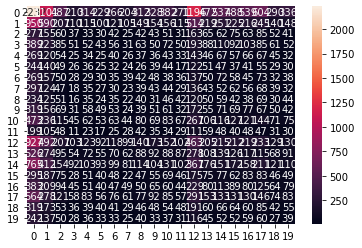

In [35]:
confusionMatrix = confusion_matrix(test_y, dummyPredictions)
seaborn.heatmap(confusionMatrix, annot = True, fmt = ".0f")

#### 'most_frequent' Dummy Classification

In [10]:
dummyClassifier = DummyClassifier(strategy = 'most_frequent')
dummyClassifier = dummyClassifier.fit(vectorTrainProc, train_y)

In [11]:
dummyPredictions = dummyClassifier.predict(vectorTestProc)

print('__MOST_FREQ. DUMMY CLASSIFIER RESULTS__',  "\n" )
print('Accuracy: ', metrics.accuracy_score(test_y, dummyPredictions))
print('F1 Macro: ', metrics.f1_score(test_y, dummyPredictions, average = 'macro'), "\n")
print('Clasification Report: ', "\n" , metrics.classification_report(test_y, dummyPredictions, zero_division = 0))

__MOST_FREQ. DUMMY CLASSIFIER RESULTS__ 

Accuracy:  0.21596
F1 Macro:  0.017760452646468635 

Clasification Report:  
               precision    recall  f1-score   support

           0       0.22      1.00      0.36     10798
           1       0.00      0.00      0.00      4830
          10       0.00      0.00      0.00      1432
          11       0.00      0.00      0.00      1949
          12       0.00      0.00      0.00      1265
          13       0.00      0.00      0.00      1114
          14       0.00      0.00      0.00      1306
          15       0.00      0.00      0.00      1244
          16       0.00      0.00      0.00      1153
          17       0.00      0.00      0.00      1545
          18       0.00      0.00      0.00      2417
          19       0.00      0.00      0.00      1010
           2       0.00      0.00      0.00      4534
           3       0.00      0.00      0.00      2605
           4       0.00      0.00      0.00      3716
           5   

## Decision Tree Classification

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
decisionTreeClassif = DecisionTreeClassifier(criterion = "entropy", min_samples_split = 10)
params = {
    'criterion' : ["entropy", "gini"],
    'max_depth':[2,4,6,8,10,12],
    "max_features": ['auto', 'log2', 'sqrt']
}

gridSCV = GridSearchCV(estimator = decisionTreeClassif, param_grid = params, scoring = 'f1_macro',  cv = 5, n_jobs = 6, verbose = 1)
gridSCV.fit(vectorTrainProc, train_y)
decisionTreeClassif = decisionTreeClassif.fit(vectorTrainProc, train_y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.9s
[Parallel(n_jobs=6)]: Done 180 out of 180 | elapsed:   11.6s finished


In [22]:
treePredictions = decisionTreeClassif.predict(vectorTestProc)


print('__DECISION TREE CLASSIFIER RESULTS__',  "\n" )
print('Accuracy: ', metrics.accuracy_score(test_y, treePredictions))
print('F1 Macro: ', metrics.f1_score(test_y, treePredictions, average = 'macro'), "\n")
print('Clasification Report: ', "\n" , metrics.classification_report(test_y, treePredictions, zero_division = 0))

__DECISION TREE CLASSIFIER RESULTS__ 

Accuracy:  0.23088
F1 Macro:  0.14341690261387505 

Clasification Report:  
               precision    recall  f1-score   support

           0       0.28      0.53      0.37     10798
           1       0.14      0.17      0.15      4830
          10       0.07      0.08      0.07      1432
          11       0.42      0.28      0.34      1949
          12       0.25      0.29      0.27      1265
          13       0.05      0.03      0.04      1114
          14       0.04      0.02      0.03      1306
          15       0.09      0.03      0.05      1244
          16       0.04      0.02      0.02      1153
          17       0.45      0.57      0.50      1545
          18       0.16      0.05      0.08      2417
          19       0.03      0.02      0.02      1010
           2       0.21      0.30      0.24      4534
           3       0.11      0.04      0.05      2605
           4       0.44      0.23      0.30      3716
           5       

<AxesSubplot:>

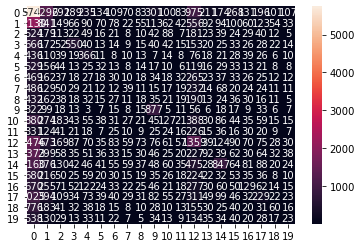

In [23]:
confusionMatrix = confusion_matrix(test_y, treePredictions)
seaborn.heatmap(confusionMatrix, annot = True, fmt = ".0f")

## C-Support Vector Classification (VERY SLOW TRAINING)

In [ ]:
%%time
cSuppVector = SVC(C = 1, verbose = 1)
params = {
    'gamma' : ['scale', 'auto'],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'decision_function_shape': ['ovo', 'ovr']
}
              
cSuppVector = GridSearchCV(estimator = cSuppVector, param_grid = params, scoring = 'f1_macro', cv = 3, n_jobs = 6, verbose = 1)
cSuppVector = cSuppVector.fit(vectorTrainProc, train_y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


In [15]:
cSuppVectorPredictions = cSuppVector.predict(vectorTestProc)


print('__C-SUPPORT VECTOR CLASSIFIER RESULTS__',  "\n" )
print('Accuracy: ', metrics.accuracy_score(test_y, cSuppVectorPredictions))
print('F1 Macro: ', metrics.f1_score(test_y, cSuppVectorPredictions, average = 'macro'), "\n")
print('Clasification Report: ', "\n" , metrics.classification_report(test_y, cSuppVectorPredictions, zero_division = 0))

__C-SUPPORT VECTOR CLASSIFIER RESULTS__ 

Accuracy:  0.29464
F1 Macro:  0.15241952139866102 

Clasification Report:  
               precision    recall  f1-score   support

           0       0.26      0.83      0.40     10798
           1       0.22      0.13      0.16      4830
          10       0.18      0.04      0.07      1432
          11       0.74      0.25      0.37      1949
          12       0.44      0.25      0.32      1265
          13       0.46      0.02      0.03      1114
          14       0.00      0.00      0.00      1306
          15       0.45      0.01      0.01      1244
          16       0.31      0.00      0.01      1153
          17       0.62      0.62      0.62      1545
          18       0.32      0.03      0.06      2417
          19       0.00      0.00      0.00      1010
           2       0.28      0.42      0.33      4534
           3       0.46      0.01      0.02      2605
           4       0.64      0.24      0.34      3716
           5    

In [24]:
confusionMatrix = confusion_matrix(test_y, cSuppVectorPredictions)
seaborn.heatmap(confusionMatrix, annot = True, fmt = ".0f")

NameError: name 'cSuppVectorPredictions' is not defined

## Linear SVC 

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.svm import LinearSVC
estPipe = Pipeline([('union', FeatureUnion([
                                             ('word_vec', CountVectorizer(analyzer = 'word')),
                                             ('char_vec', CountVectorizer(analyzer = 'char'))
                                             ])),
                     ('transform', TfidfTransformer()),
                     ('clf', LinearSVC(C = 0.10, class_weight = 'balanced'
                                ))])

params = {
    'union__char_vec__binary': [True, False],
    'union__word_vec__binary': [True, False],
    'clf__loss': ['hinge', 'squared_hinge'],
}

grid_search = GridSearchCV(estimator = estPipe, param_grid = params, cv = 3, scoring = 'f1_macro', n_jobs = 6, verbose = 1)
grid_search.fit(train_x, train_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  24 out of  24 | elapsed:  2.3min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('union',
                                        FeatureUnion(transformer_list=[('word_vec',
                                                                        CountVectorizer()),
                                                                       ('char_vec',
                                                                        CountVectorizer(analyzer='char'))])),
                                       ('transform', TfidfTransformer()),
                                       ('clf',
                                        LinearSVC(C=0.1,
                                                  class_weight='balanced'))]),
             n_jobs=6,
             param_grid={'clf__loss': ['hinge', 'squared_hinge'],
                         'union__char_vec__binary': [True, False],
                         'union__word_vec__binary': [True, False]},
             scoring='f1_macro', verbose=1)

In [17]:
cSuppVectorPredictions = grid_search.predict(test_x)


print('__C-SUPPORT VECTOR CLASSIFIER RESULTS__',  "\n" )
print('Accuracy: ', metrics.accuracy_score(test_y, cSuppVectorPredictions))
print('F1 Macro: ', metrics.f1_score(test_y, cSuppVectorPredictions, average = 'macro'), "\n")
print('Clasification Report: ', "\n" , metrics.classification_report(test_y, cSuppVectorPredictions, zero_division = 0))

__C-SUPPORT VECTOR CLASSIFIER RESULTS__ 

Accuracy:  0.22754
F1 Macro:  0.19953461422717372 

Clasification Report:  
               precision    recall  f1-score   support

           0       0.44      0.18      0.26     10798
           1       0.29      0.11      0.16      4830
          10       0.10      0.15      0.12      1432
          11       0.39      0.55      0.46      1949
          12       0.19      0.52      0.28      1265
          13       0.07      0.10      0.08      1114
          14       0.05      0.09      0.07      1306
          15       0.11      0.26      0.15      1244
          16       0.07      0.10      0.08      1153
          17       0.47      0.78      0.59      1545
          18       0.18      0.19      0.18      2417
          19       0.04      0.09      0.06      1010
           2       0.37      0.31      0.33      4534
           3       0.13      0.09      0.11      2605
           4       0.42      0.41      0.42      3716
           5    

In [ ]:
confusionMatrix = confusion_matrix(test_y, cSuppVectorPredictions)
seaborn.heatmap(confusionMatrix, annot = True, fmt = ".0f")

## Random Forest Classifier

In [25]:
x_train, x_test, y_train, y_test = train_test_split(
    train_x, train_y, test_size = 0.33, random_state = 0, shuffle = True)
params = { 
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,6,8],
    'criterion' :['gini', 'entropy']
}

classifier = Pipeline([("tf-idf", TfidfVectorizer()), ("classr", RandomForestClassifier(
        n_estimators = 100, warm_start = True, verbose = 1))])

grid_search = GridSearchCV(estimator = classifier, param_grid = params, cv = 3, scoring = 'f1_macro', n_jobs = 6, verbose = 1)
grid_search.fit(train_x, train_y)

#classifier.fit(train_x, train_y)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


ValueError: Invalid parameter criterion for estimator Pipeline(steps=[('tf-idf', TfidfVectorizer()),
                ('classr', RandomForestClassifier(verbose=1, warm_start=True))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
forrestPredictions = grid_search.predict(test_x)

print('__FOREST CLASSIFIER RESULTS__',  "\n" )
print('Accuracy: ', metrics.accuracy_score(test_y, forrestPredictions))
print('F1 Macro: ', metrics.f1_score(test_y, forrestPredictions, average = 'macro'), "\n")
print('Clasification Report: ', "\n" , metrics.classification_report(test_y, forrestPredictions, zero_division = 0))

In [ ]:
confusionMatrix = confusion_matrix(test_y, forrestPredictions)
seaborn.heatmap(confusionMatrix, annot = True, fmt = ".0f")